##  Load dan Siapkan Dataset Sign Language MNIST

Kita menggunakan dataset Sign Language MNIST dari Kaggle yang formatnya berupa file `.csv`, mirip MNIST klasik. Masing-masing baris adalah satu gambar berukuran 28x28 piksel dalam format grayscale, dengan label di kolom pertama dan 784 nilai piksel berikutnya.

Karena kita membuat **autoencoder**, kita hanya butuh data gambar saja (tanpa label) — karena tujuannya adalah mempelajari representasi gambar dan merekonstruksi input itu sendiri.


In [33]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

# Load data CSV
train_df = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_train.csv')
test_df = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_test.csv')

# Pisahkan label dan data
X_train = train_df.iloc[:, 1:].values.astype(np.float32).reshape(-1, 28, 28)
y_train = train_df.iloc[:, 0].values

X_test = test_df.iloc[:, 1:].values.astype(np.float32).reshape(-1, 28, 28)
y_test = test_df.iloc[:, 0].values

# Normalisasi ke [0, 1]
X_train /= 255.0
X_test /= 255.0


##  Dataset PyTorch untuk Autoencoder

Kita membuat class `SignLanguageDataset` agar dapat digunakan oleh `DataLoader` PyTorch. Karena autoencoder mempelajari "memampatkan" dan "mengembalikan" gambar, kita atur agar setiap sample mengembalikan `(gambar, gambar)` sebagai `(input, target)`.

Transformasi yang digunakan adalah `ToTensor()` supaya gambar berubah menjadi tensor 1×28×28.


In [34]:
class SignLanguageDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        image = self.transform(image)  # Jadi tensor: (1, 28, 28)
        return image, image  # Target-nya sama seperti input (autoencoder)


In [35]:
# Buat objek dataset dan dataloader
train_dataset = SignLanguageDataset(X_train)
test_dataset = SignLanguageDataset(X_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


##  CNN Autoencoder

arsitektur **Convolutional Autoencoder** dengan 3 layer encoder dan 3 layer decoder. Encoder akan mengekstrak fitur dari gambar dan mereduksi dimensinya ke dalam **latent space**. Decoder akan mencoba membalikkan proses itu, mengembalikan gambar aslinya dari representasi latent.

- Encoder:
  - Conv2D → ReLU → MaxPool
  - 3 kali
- Decoder:
  - ConvTranspose2D → ReLU
  - 3 kali


In [36]:
class CNN_Autoencoder(nn.Module):
    def __init__(self):
        super(CNN_Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),     # (1,28,28) -> (16,28,28)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                 # (16,28,28) -> (16,14,14)

            nn.Conv2d(16, 32, 3, padding=1),    # (16,14,14) -> (32,14,14)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                 # (32,14,14) -> (32,7,7)

            nn.Conv2d(32, 64, 3, padding=1),    # (32,7,7) -> (64,7,7)
            nn.ReLU(),
            nn.MaxPool2d(2, 2)                  # (64,7,7) -> (64,3,3)
        )

        # Decoder (fix ukuran output jadi 28x28)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2),                             # (64,3,3) -> (32,7,7)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # (32,7,7) -> (16,14,14)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),   # (16,14,14) -> (1,28,28)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


Autoencoder di atas dirancang untuk:
- Input: Gambar 1×28×28
- Latent space: (64, 3, 3) = 576 dimensi
- Output: Gambar kembali ke 1×28×28

Setelah ini, kita akan melatih model ini dengan loss function MSELoss dan optimizer Adam.


##  Perbaikan Decoder: Menyesuaikan Ukuran Output

Sebelumnya model error karena hasil output dari decoder tidak sama ukuran dengan input (28x28). Ini karena `ConvTranspose2d` harus diatur `padding` dan `output_padding`-nya agar bisa memproduksi ukuran akhir yang pas.

Dengan pengaturan baru:
- Input: (1, 28, 28)
- Output: (1, 28, 28)


##  Training Model Autoencoder

Kita akan melatih model autoencoder menggunakan fungsi loss `MSELoss` (karena kita ingin output-nya semirip mungkin dengan input). Optimizer yang digunakan adalah `Adam`.

Model akan dilatih selama 20 epoch (bisa disesuaikan), dan kita akan menyimpan loss tiap epoch untuk divisualisasikan nanti.


In [37]:
import torch.optim as optim

# Gunakan GPU jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Panggil model dan kirim ke device
model = CNN_Autoencoder().to(device)

# Gunakan MSELoss untuk menghitung selisih input dan output
criterion = nn.MSELoss()

# Optimizer Adam
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Jumlah epoch training
num_epochs = 20
train_losses = []

# Mulai loop training
for epoch in range(num_epochs):
    model.train()  # Set mode training
    running_loss = 0.0

    for data, _ in train_loader:
        inputs = data.to(device)  # Kirim data ke GPU

        optimizer.zero_grad()          # Reset gradien
        outputs = model(inputs)        # Forward pass
        loss = criterion(outputs, inputs)  # Hitung loss
        loss.backward()                # Backpropagation
        optimizer.step()               # Update bobot

        running_loss += loss.item()    # Tambah loss total

    # Rata-rata loss per epoch
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/20], Loss: 0.0142
Epoch [2/20], Loss: 0.0070
Epoch [3/20], Loss: 0.0059
Epoch [4/20], Loss: 0.0053
Epoch [5/20], Loss: 0.0049
Epoch [6/20], Loss: 0.0046
Epoch [7/20], Loss: 0.0044
Epoch [8/20], Loss: 0.0042
Epoch [9/20], Loss: 0.0041
Epoch [10/20], Loss: 0.0039
Epoch [11/20], Loss: 0.0038
Epoch [12/20], Loss: 0.0037
Epoch [13/20], Loss: 0.0036
Epoch [14/20], Loss: 0.0036
Epoch [15/20], Loss: 0.0035
Epoch [16/20], Loss: 0.0034
Epoch [17/20], Loss: 0.0033
Epoch [18/20], Loss: 0.0033
Epoch [19/20], Loss: 0.0032
Epoch [20/20], Loss: 0.0032


##  Visualisasi Gambar: Asli vs Rekonstruksi

Kita akan mengambil beberapa sample dari data uji, lalu kita tampilkan:
- Gambar aslinya
- Hasil rekonstruksi dari model autoencoder

Ini penting untuk melihat seberapa baik model bisa memahami dan membentuk kembali gambar tangan (sign language).


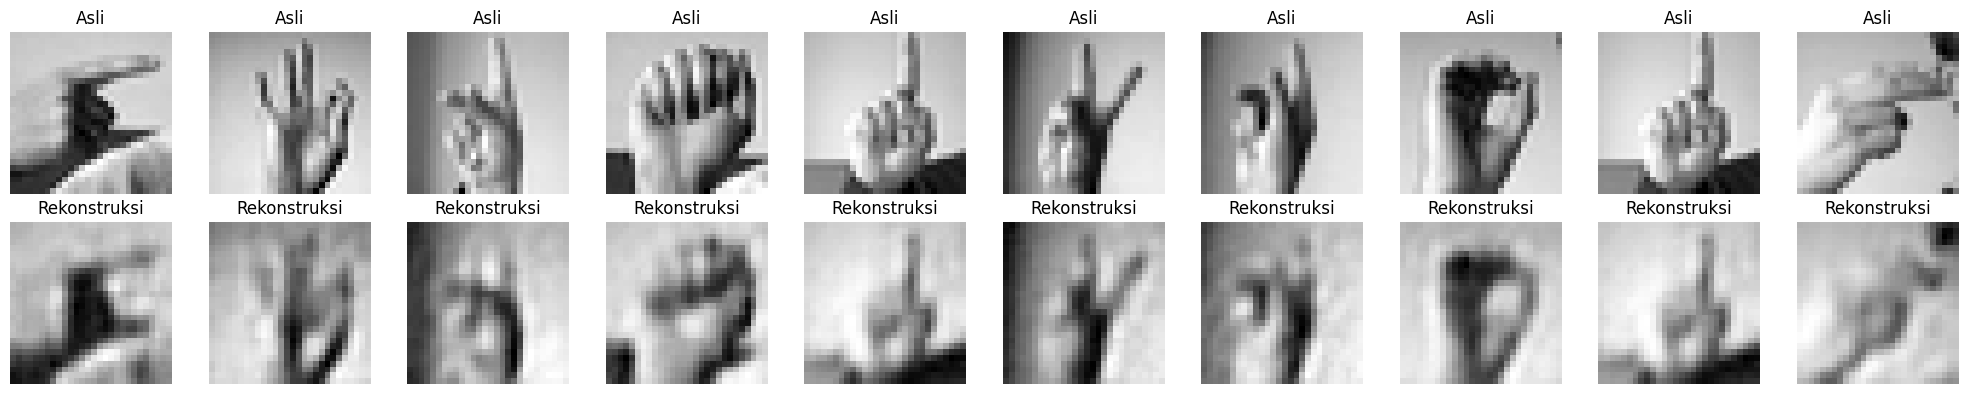

In [38]:
model.eval()

with torch.no_grad():
    dataiter = iter(test_loader)
    images, _ = next(dataiter)
    images = images.to(device)

    outputs = model(images)

# Pindahkan ke CPU dan convert ke numpy
images = images.cpu().numpy()
outputs = outputs.cpu().numpy()

# Tampilkan 10 gambar asli dan hasil rekonstruksinya
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Gambar asli
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i].reshape(28, 28), cmap="gray")
    plt.title("Asli")
    plt.axis("off")

    # Gambar hasil rekonstruksi
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(outputs[i].reshape(28, 28), cmap="gray")
    plt.title("Rekonstruksi")
    plt.axis("off")

plt.tight_layout()
plt.show()


##  Visualisasi Latent Space dengan t-SNE

Kita mengambil representasi latent dari encoder, lalu mereduksinya menjadi 2 dimensi menggunakan t-SNE. Tujuannya adalah melihat apakah gambar-gambar yang serupa memiliki representasi latent yang berdekatan.

Setiap titik pada scatter plot mewakili 1 gambar, dan warna menunjukkan label aslinya.



latents_2d: (7172, 2)
all_labels: (5622848,)


/tmp/ipykernel_35/4128289044.py:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


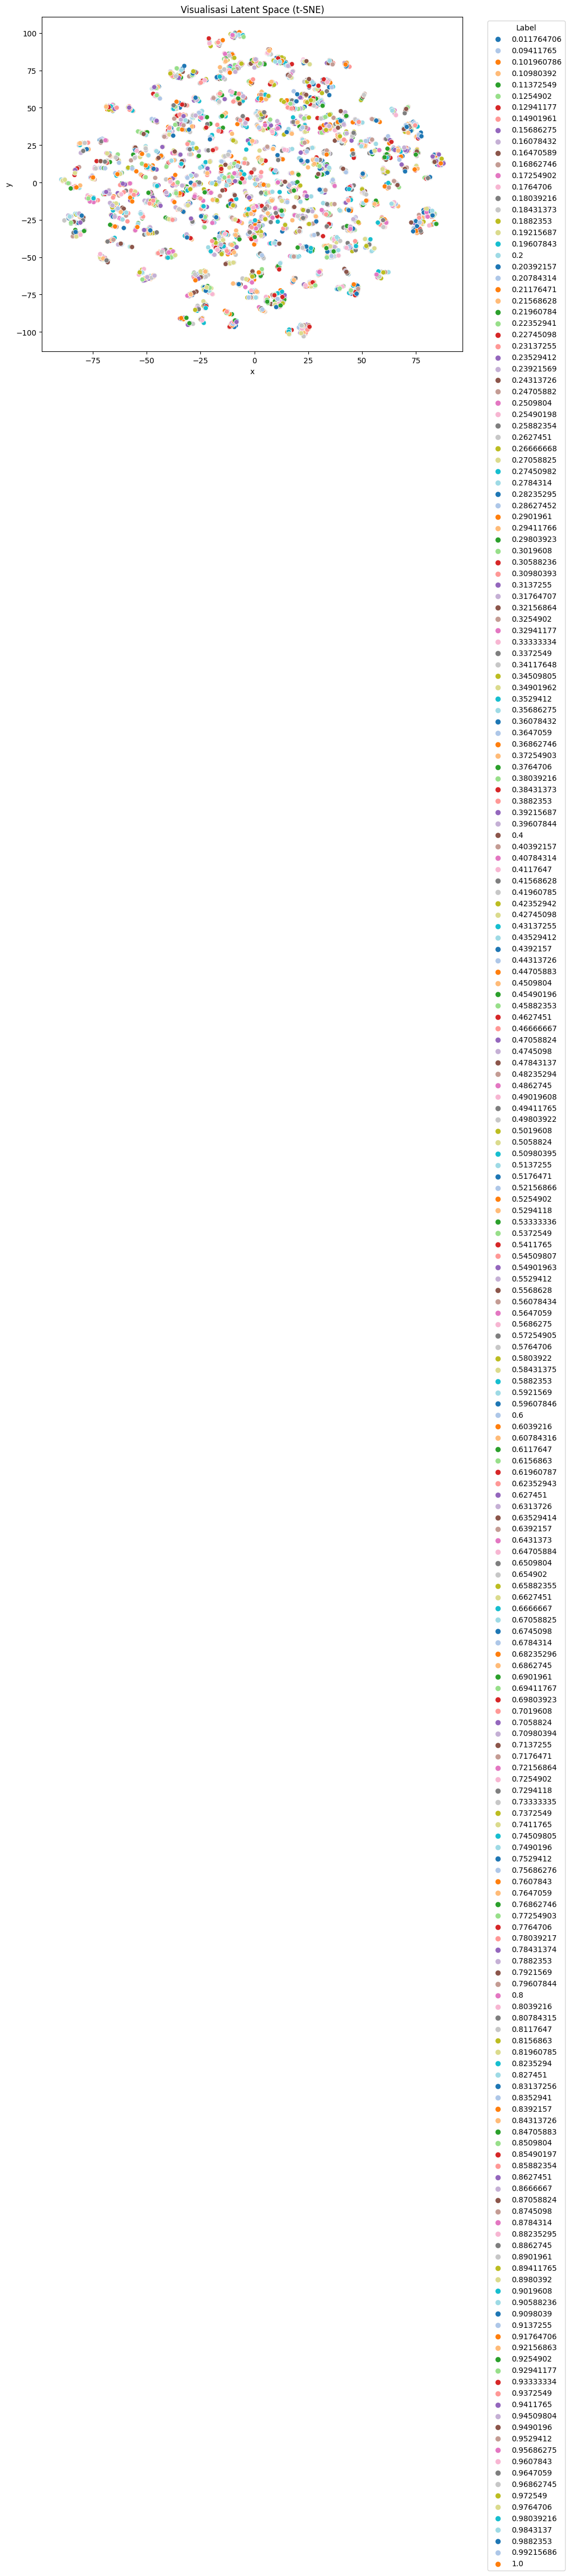

In [39]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Kumpulkan representasi latent + label
all_latents = []
all_labels = []

model.eval()
with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device)
        encoded = encoder(data)
        encoded = encoded.view(encoded.size(0), -1)  # (batch, latent_dim)
        all_latents.append(encoded.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Gabungkan semua batch
all_latents = np.concatenate(all_latents, axis=0)
all_labels = np.concatenate(all_labels, axis=0) 
all_labels = all_labels.ravel()  

# Reduksi dimensi dari latent space ke 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
latents_2d = tsne.fit_transform(all_latents)
print("latents_2d:", latents_2d.shape)  # Harus (7172, 2)
print("all_labels:", all_labels.shape)  # Harus (7172,)

# Buat DataFrame untuk visualisasi
min_len = min(latents_2d.shape[0], all_labels.shape[0])
df_tsne = pd.DataFrame({
    'x': latents_2d[:min_len, 0],
    'y': latents_2d[:min_len, 1],
    'label': all_labels[:min_len]
})


# Visualisasi t-SNE
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_tsne, x='x', y='y', hue='label', palette='tab20', s=40)
plt.title("Visualisasi Latent Space (t-SNE)")
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

##  Menyimpan Model Autoencoder

Model disimpan dalam format `.pth` agar bisa digunakan kembali untuk inferensi atau lanjutan pelatihan. File ini berisi seluruh bobot (weights) dari model yang sudah dilatih.


In [40]:
# Simpan model
model_path = "autoencoder_signmnist.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to autoencoder_signmnist.pth
